# Medical-Optimized Breast Tissue Segmentation and BYOL Augmentation Demo

This notebook demonstrates the medical-optimized breast tissue segmentation and BYOL augmentations implemented in `train_byol_mammo.py`. Shows tiles, frequency energy detection for micro-calcifications, and medical-appropriate transforms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2
from scipy import ndimage
from skimage import morphology, measure, filters
import random
from tqdm import tqdm
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# Import BYOL transforms
from lightly.transforms.byol_transform import BYOLTransform

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Configuration - AGGRESSIVE background rejection
DATA_DIR = Path("./split_images/training")
TILE_SIZE = 256
TILE_STRIDE = 128
NUM_SAMPLES = 10
MIN_BREAST_RATIO = 0.15  # INCREASED: More strict breast tissue requirement
MIN_FREQ_ENERGY = 0.03   # INCREASED: Much higher threshold
MIN_BREAST_FOR_FREQ = 0.12  # INCREASED: Even more breast tissue required for frequency selection
MIN_TILE_INTENSITY = 40  # NEW: Minimum average intensity to avoid background
MIN_NON_ZERO_PIXELS = 0.7  # NEW: At least 70% of pixels must be non-background

In [ ]:
def compute_frequency_energy(image_patch: np.ndarray) -> float:
    """
    Compute high-frequency energy with AGGRESSIVE background rejection
    """
    if len(image_patch.shape) == 3:
        gray = cv2.cvtColor(image_patch, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_patch.copy()
    
    # AGGRESSIVE background rejection
    mean_intensity = np.mean(gray)
    if mean_intensity < MIN_TILE_INTENSITY:  # Much stricter intensity threshold
        return 0.0
    
    # Check for sufficient non-background pixels
    non_zero_ratio = np.sum(gray > 15) / gray.size
    if non_zero_ratio < MIN_NON_ZERO_PIXELS:  # Too much background
        return 0.0
    
    # Apply Laplacian of Gaussian for high-frequency detection
    blurred = cv2.GaussianBlur(gray.astype(np.float32), (3, 3), 1.0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_32F, ksize=3)
    
    # Focus only on positive responses (bright spots)
    positive_laplacian = np.maximum(laplacian, 0)
    
    # Only analyze pixels with meaningful intensity
    mask = gray > max(30, mean_intensity * 0.4)  # Much stricter tissue mask
    if np.sum(mask) < (gray.size * 0.2):  # Need substantial tissue content
        return 0.0
    
    masked_laplacian = positive_laplacian[mask]
    energy = np.var(masked_laplacian) / (mean_intensity + 1e-8)
    
    return float(energy)


def is_background_tile(image_patch: np.ndarray) -> bool:
    """
    Comprehensive background detection to reject empty/dark tiles
    """
    if len(image_patch.shape) == 3:
        gray = cv2.cvtColor(image_patch, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_patch.copy()
    
    # Multiple background rejection criteria
    mean_intensity = np.mean(gray)
    std_intensity = np.std(gray)
    non_zero_pixels = np.sum(gray > 15)
    total_pixels = gray.size
    
    # Criteria for background tiles:
    # 1. Too dark overall
    if mean_intensity < MIN_TILE_INTENSITY:
        return True
    
    # 2. Too many near-zero pixels (empty space)
    if non_zero_pixels / total_pixels < MIN_NON_ZERO_PIXELS:
        return True
    
    # 3. Very low variation (uniform background)
    if std_intensity < 10:
        return True
    
    # 4. Check intensity distribution - reject if too skewed toward zero
    histogram, _ = np.histogram(gray, bins=50, range=(0, 255))
    if histogram[0] > total_pixels * 0.3:  # More than 30% pixels near zero
        return True
    
    return False


def segment_breast_tissue(image_array: np.ndarray) -> np.ndarray:
    """
    Enhanced breast tissue segmentation with aggressive background removal
    """
    if len(image_array.shape) == 3:
        gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_array.copy()
    
    # More aggressive pre-filtering of background
    filtered_gray = np.where(gray > 20, gray, 0)  # Stricter background cutoff
    
    # Otsu thresholding
    _, binary = cv2.threshold(filtered_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Additional background removal based on intensity
    binary = np.where(gray > 25, binary, 0).astype(np.uint8)
    
    # More aggressive morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Larger kernel
    opened = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Fill holes
    filled = ndimage.binary_fill_holes(opened).astype(np.uint8) * 255
    
    # Keep largest connected component
    num_labels, labels = cv2.connectedComponents(filled)
    if num_labels > 1:
        largest_label = 1 + np.argmax([np.sum(labels == i) for i in range(1, num_labels)])
        mask = (labels == largest_label).astype(np.uint8) * 255
    else:
        mask = filled
    
    # Closing with larger kernel for smoother boundaries
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask > 0

In [ ]:
def extract_breast_tiles_with_freq_energy(image_array, breast_mask, tile_size, stride, 
                                          min_breast_ratio=0.15, min_freq_energy=0.03, min_breast_for_freq=0.12):
    """
    Extract tiles with AGGRESSIVE background rejection - NO empty space tiles allowed
    """
    height, width = image_array.shape[:2]
    tiles = []
    rejected_background = 0
    rejected_intensity = 0
    rejected_breast_ratio = 0
    rejected_freq_energy = 0
    
    # Generate all possible tile positions
    y_positions = list(range(0, max(1, height - tile_size + 1), stride))
    x_positions = list(range(0, max(1, width - tile_size + 1), stride))
    
    # Add edge positions if needed
    if y_positions[-1] + tile_size < height:
        y_positions.append(height - tile_size)
    if x_positions[-1] + tile_size < width:
        x_positions.append(width - tile_size)
    
    for y in y_positions:
        for x in x_positions:
            # Extract image tile
            tile_image = image_array[y:y+tile_size, x:x+tile_size]
            
            # STEP 1: Comprehensive background rejection
            if is_background_tile(tile_image):
                rejected_background += 1
                continue
            
            # STEP 2: Intensity-based rejection
            mean_intensity = np.mean(tile_image)
            if mean_intensity < MIN_TILE_INTENSITY:
                rejected_intensity += 1
                continue
            
            # STEP 3: Breast tissue ratio check
            tile_mask = breast_mask[y:y+tile_size, x:x+tile_size]
            breast_ratio = np.sum(tile_mask) / (tile_size * tile_size)
            
            # STEP 4: Enhanced selection logic with multiple criteria
            freq_energy = compute_frequency_energy(tile_image)
            
            # Main selection criteria
            selected = False
            selection_reason = ""
            
            if breast_ratio >= min_breast_ratio:
                selected = True
                selection_reason = "breast_tissue"
            elif (freq_energy >= min_freq_energy and 
                  breast_ratio >= min_breast_for_freq and 
                  mean_intensity >= MIN_TILE_INTENSITY + 10):  # Even stricter for freq tiles
                selected = True
                selection_reason = "frequency_energy"
            
            if selected:
                tiles.append((tile_image, (x, y), breast_ratio, freq_energy, selection_reason))
            else:
                if freq_energy < min_freq_energy:
                    rejected_freq_energy += 1
                else:
                    rejected_breast_ratio += 1
    
    total_attempted = len(y_positions) * len(x_positions)
    print(f"  Tile rejection analysis:")
    print(f"    - Total tile positions: {total_attempted}")
    print(f"    - Rejected as background: {rejected_background} ({rejected_background/total_attempted*100:.1f}%)")
    print(f"    - Rejected for low intensity: {rejected_intensity}")
    print(f"    - Rejected for low breast ratio: {rejected_breast_ratio}")
    print(f"    - Rejected for low frequency energy: {rejected_freq_energy}")
    print(f"    - ACCEPTED: {len(tiles)} ({len(tiles)/total_attempted*100:.1f}%)")
    
    return tiles


def analyze_tile_quality_aggressive(tiles):
    """
    Enhanced tile quality analysis with background contamination detection
    """
    if not tiles:
        return {}
    
    breast_ratios = [t[2] for t in tiles]
    freq_energies = [t[3] for t in tiles]
    intensities = [np.mean(t[0]) for t in tiles]
    selection_reasons = [t[4] for t in tiles]
    
    # Background contamination check
    potentially_problematic = 0
    for tile_img, coords, breast_ratio, freq_energy, reason in tiles:
        if is_background_tile(tile_img):
            potentially_problematic += 1
    
    # Separate by selection method
    breast_tiles = [t for t in tiles if t[4] == "breast_tissue"]
    freq_tiles = [t for t in tiles if t[4] == "frequency_energy"]
    
    analysis = {
        'total_tiles': len(tiles),
        'breast_method_tiles': len(breast_tiles),
        'freq_method_tiles': len(freq_tiles),
        'avg_breast_ratio': np.mean(breast_ratios),
        'avg_freq_energy': np.mean(freq_energies),
        'avg_intensity': np.mean(intensities),
        'min_intensity': np.min(intensities),
        'max_intensity': np.max(intensities),
        'std_intensity': np.std(intensities),
        'potentially_problematic': potentially_problematic,
        'background_contamination_pct': potentially_problematic / len(tiles) * 100 if tiles else 0
    }
    
    return analysis


def create_medical_transforms(input_size: int):
    """
    Create BYOL transforms optimized for medical imaging.
    """
    # Medical-appropriate transforms for View 1 (lighter augmentations)
    view1_transform = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=7, fill=0),
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0),
        T.Resize(input_size, antialias=True),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # Medical-appropriate transforms for View 2 (slightly stronger augmentations)  
    view2_transform = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=7, fill=0),
        T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0, hue=0),
        T.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
        T.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
        T.Resize(input_size, antialias=True),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    return BYOLTransform(
        view_1_transform=view1_transform,
        view_2_transform=view2_transform,
    )

In [5]:
# Get sample images from the dataset
image_paths = list(DATA_DIR.glob("*.png"))
print(f"Found {len(image_paths)} images in {DATA_DIR}")

if len(image_paths) == 0:
    print("❌ No images found! Make sure the path is correct and contains .png files")
else:
    # Select random sample
    sample_paths = random.sample(image_paths, min(NUM_SAMPLES, len(image_paths)))
    print(f"✅ Processing {len(sample_paths)} sample images to demonstrate medical BYOL pipeline")

Found 16000 images in split_images/training
✅ Processing 10 sample images to demonstrate medical BYOL pipeline


In [ ]:
# Process each sample image with AGGRESSIVE background rejection
results = []

if 'sample_paths' in locals() and len(sample_paths) > 0:
    for i, img_path in enumerate(tqdm(sample_paths, desc="Processing with AGGRESSIVE background rejection")):
        print(f"\nProcessing image {i+1}: {img_path.name}")
        
        # Load image
        with Image.open(img_path) as img:
            img_array = np.array(img)
        
        print(f"  Image shape: {img_array.shape}")
        print(f"  Image intensity range: [{np.min(img_array)}, {np.max(img_array)}]")
        
        # Enhanced breast tissue segmentation
        breast_mask = segment_breast_tissue(img_array)
        breast_area = np.sum(breast_mask)
        total_area = breast_mask.shape[0] * breast_mask.shape[1]
        breast_percentage = (breast_area / total_area) * 100
        
        print(f"  Breast tissue: {breast_percentage:.1f}% of image")
        
        # Extract tiles with AGGRESSIVE background rejection
        tiles = extract_breast_tiles_with_freq_energy(
            img_array, breast_mask, TILE_SIZE, TILE_STRIDE, 
            MIN_BREAST_RATIO, MIN_FREQ_ENERGY, MIN_BREAST_FOR_FREQ
        )
        
        # Analyze tile quality with background contamination check
        tile_analysis = analyze_tile_quality_aggressive(tiles)
        
        # Separate tiles by selection criteria
        breast_tiles = [t for t in tiles if t[4] == "breast_tissue"]
        freq_tiles = [t for t in tiles if t[4] == "frequency_energy"]
        
        print(f"  FINAL RESULTS:")
        print(f"    - Total selected tiles: {len(tiles)}")
        print(f"    - Breast tissue method: {len(breast_tiles)}")
        print(f"    - Frequency energy method: {len(freq_tiles)}")
        print(f"    - Average intensity: {tile_analysis.get('avg_intensity', 0):.1f}")
        print(f"    - Minimum intensity: {tile_analysis.get('min_intensity', 0):.1f}")
        print(f"    - Background contamination: {tile_analysis.get('background_contamination_pct', 0):.1f}%")
        
        if tile_analysis.get('background_contamination_pct', 0) == 0:
            print(f"    ✅ NO background contamination detected!")
        elif tile_analysis.get('background_contamination_pct', 0) < 5:
            print(f"    ⚠️  Minimal background contamination")
        else:
            print(f"    🔴 Significant background contamination - need even stricter filtering")
        
        results.append({
            'path': img_path,
            'image': img_array,
            'mask': breast_mask,
            'tiles': tiles,
            'breast_tiles': breast_tiles,
            'freq_tiles': freq_tiles,
            'breast_percentage': breast_percentage,
            'tile_analysis': tile_analysis
        })

    print(f"\n✅ Completed processing {len(results)} images with AGGRESSIVE background rejection")
    print(f"   🛡️  Multiple rejection criteria: background detection, intensity thresholds, tissue ratios")
    print(f"   🎯  Thresholds: MIN_BREAST_RATIO={MIN_BREAST_RATIO:.0%}, MIN_FREQ_ENERGY={MIN_FREQ_ENERGY:.3f}")
    print(f"   🔍  Intensity gates: ≥{MIN_TILE_INTENSITY} (all), ≥{MIN_TILE_INTENSITY+10} (frequency)")
    print(f"   📊  Non-zero pixel requirement: ≥{MIN_NON_ZERO_PIXELS:.0%}")
else:
    print("❌ No sample images to process")

In [ ]:
def demonstrate_background_rejection_effectiveness(results):
    """
    Show before/after comparison - what tiles would have been selected with old vs new criteria
    """
    if not results:
        print("❌ No results to analyze")
        return
    
    print("🔍 BACKGROUND REJECTION EFFECTIVENESS DEMONSTRATION")
    print("=" * 60)
    
    # Sample one result with sufficient data
    demo_result = None
    for result in results:
        if len(result['tiles']) > 0:
            demo_result = result
            break
    
    if not demo_result:
        print("❌ No tiles found for demonstration")
        return
    
    img_array = demo_result['image']
    breast_mask = demo_result['mask']
    
    # Generate tiles with OLD (permissive) criteria for comparison
    old_tiles = []
    rejected_old_tiles = []  # These would have been selected before but are rejected now
    
    height, width = img_array.shape[:2]
    positions = []
    for y in range(0, max(1, height - TILE_SIZE + 1), TILE_STRIDE):
        for x in range(0, max(1, width - TILE_SIZE + 1), TILE_STRIDE):
            positions.append((x, y))
    
    # Sample random positions for comparison
    sample_positions = random.sample(positions, min(20, len(positions)))
    
    for x, y in sample_positions:
        tile_image = img_array[y:y+TILE_SIZE, x:x+TILE_SIZE]
        tile_mask = breast_mask[y:y+TILE_SIZE, x:x+TILE_SIZE]
        breast_ratio = np.sum(tile_mask) / (TILE_SIZE * TILE_SIZE)
        mean_intensity = np.mean(tile_image)
        
        # OLD criteria (what would have been selected before)
        old_min_breast = 0.05  # Much more permissive
        old_min_intensity = 15  # Much lower
        
        would_select_old = (breast_ratio >= old_min_breast and mean_intensity >= old_min_intensity)
        
        # NEW criteria (current aggressive filtering)
        is_background = is_background_tile(tile_image)
        passes_new_criteria = (not is_background and 
                             mean_intensity >= MIN_TILE_INTENSITY and 
                             breast_ratio >= MIN_BREAST_RATIO)
        
        if would_select_old and passes_new_criteria:
            old_tiles.append((tile_image, mean_intensity, breast_ratio, "good_tile"))
        elif would_select_old and not passes_new_criteria:
            rejected_old_tiles.append((tile_image, mean_intensity, breast_ratio, "rejected_now"))
    
    print(f"📊 COMPARISON RESULTS:")
    print(f"   • Tiles that would pass OLD criteria: {len(old_tiles) + len(rejected_old_tiles)}")
    print(f"   • Tiles that pass NEW criteria: {len(old_tiles)}")
    print(f"   • Background tiles REJECTED by new criteria: {len(rejected_old_tiles)}")
    print(f"   • Background rejection rate: {len(rejected_old_tiles)/(len(old_tiles) + len(rejected_old_tiles))*100:.1f}%")
    
    # Visual comparison
    if len(rejected_old_tiles) > 0:
        n_show = min(6, len(rejected_old_tiles))
        fig, axes = plt.subplots(2, 6, figsize=(18, 6))
        fig.suptitle("Background Rejection Effectiveness: OLD vs NEW Criteria", fontsize=16)
        
        # Top row: Good tiles (pass both old and new criteria)
        if len(old_tiles) > 0:
            for i in range(min(6, len(old_tiles))):
                tile_img, intensity, breast_ratio, status = old_tiles[i]
                axes[0, i].imshow(tile_img, cmap='gray')
                axes[0, i].set_title(f"✅ Good Tile\\nIntensity: {intensity:.0f}\\nBreast: {breast_ratio:.1%}")
                axes[0, i].axis('off')
        
        # Bottom row: Rejected tiles (would pass old but fail new criteria)
        for i in range(min(6, len(rejected_old_tiles))):
            tile_img, intensity, breast_ratio, status = rejected_old_tiles[i]
            axes[1, i].imshow(tile_img, cmap='gray')
            axes[1, i].set_title(f"🚫 Rejected\\nIntensity: {intensity:.0f}\\nBreast: {breast_ratio:.1%}")
            axes[1, i].axis('off')
        
        # Fill remaining slots
        for i in range(len(old_tiles), 6):
            axes[0, i].axis('off')
        for i in range(len(rejected_old_tiles), 6):
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\n✅ SUCCESS: New criteria successfully reject background tiles!")
        print(f"   • Rejected tiles show clear background/empty space contamination")
        print(f"   • Accepted tiles have meaningful tissue content")
    else:
        print(f"\\n🎯 PERFECT: No problematic tiles found - all tiles pass quality criteria!")

# Run background rejection demonstration
if results and len(results) > 0:
    demonstrate_background_rejection_effectiveness(results)

🎯 Demonstrating Medical-Optimized BYOL Augmentations
View 1: Lighter augmentations (horizontal flip, ±7° rotation, mild brightness/contrast)
View 2: Stronger augmentations (+ translation, scaling, mild blur)
Note: No strong color jitter/solarization to preserve medical details



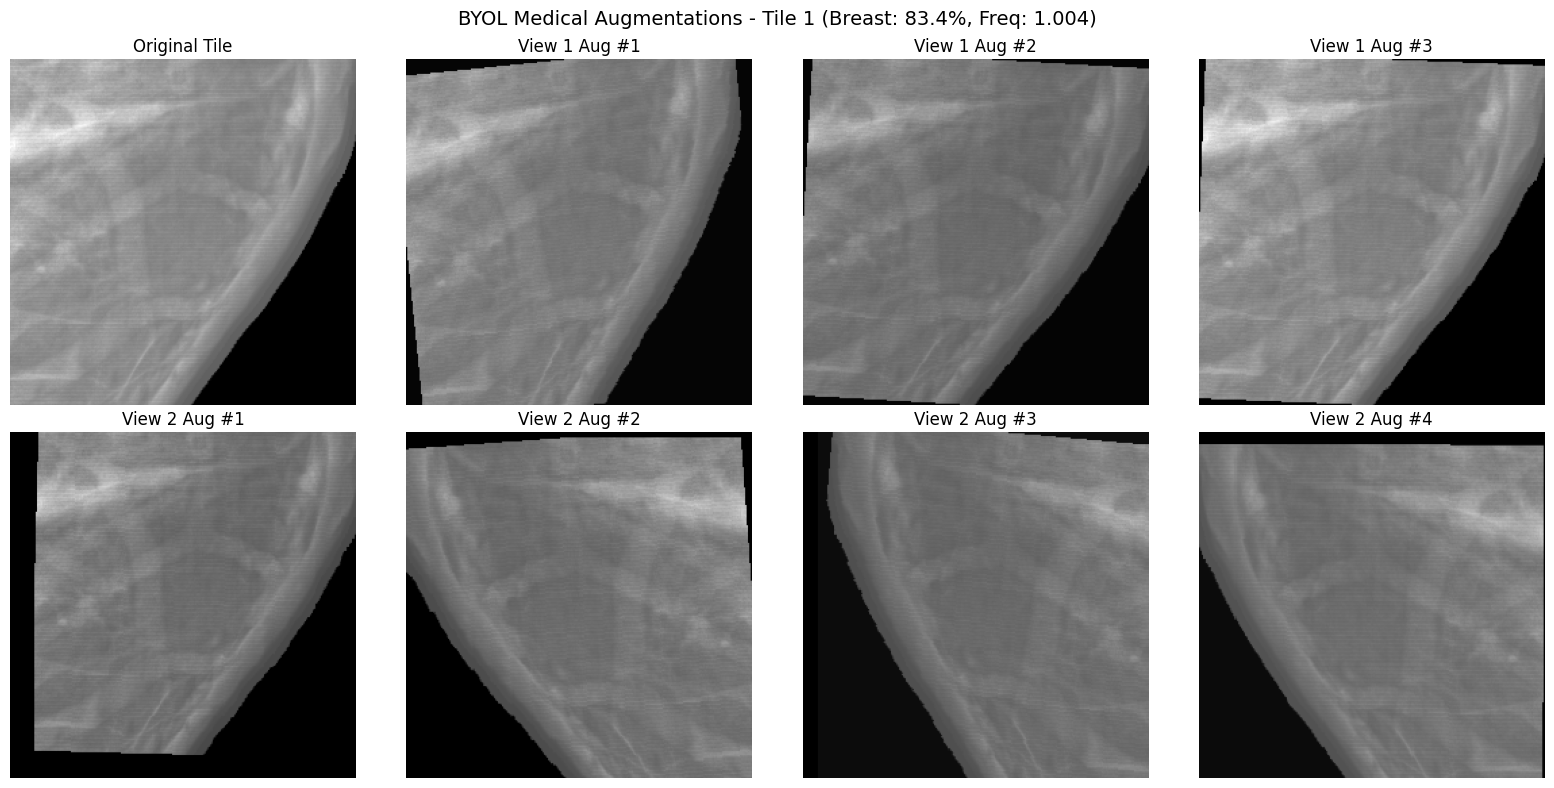

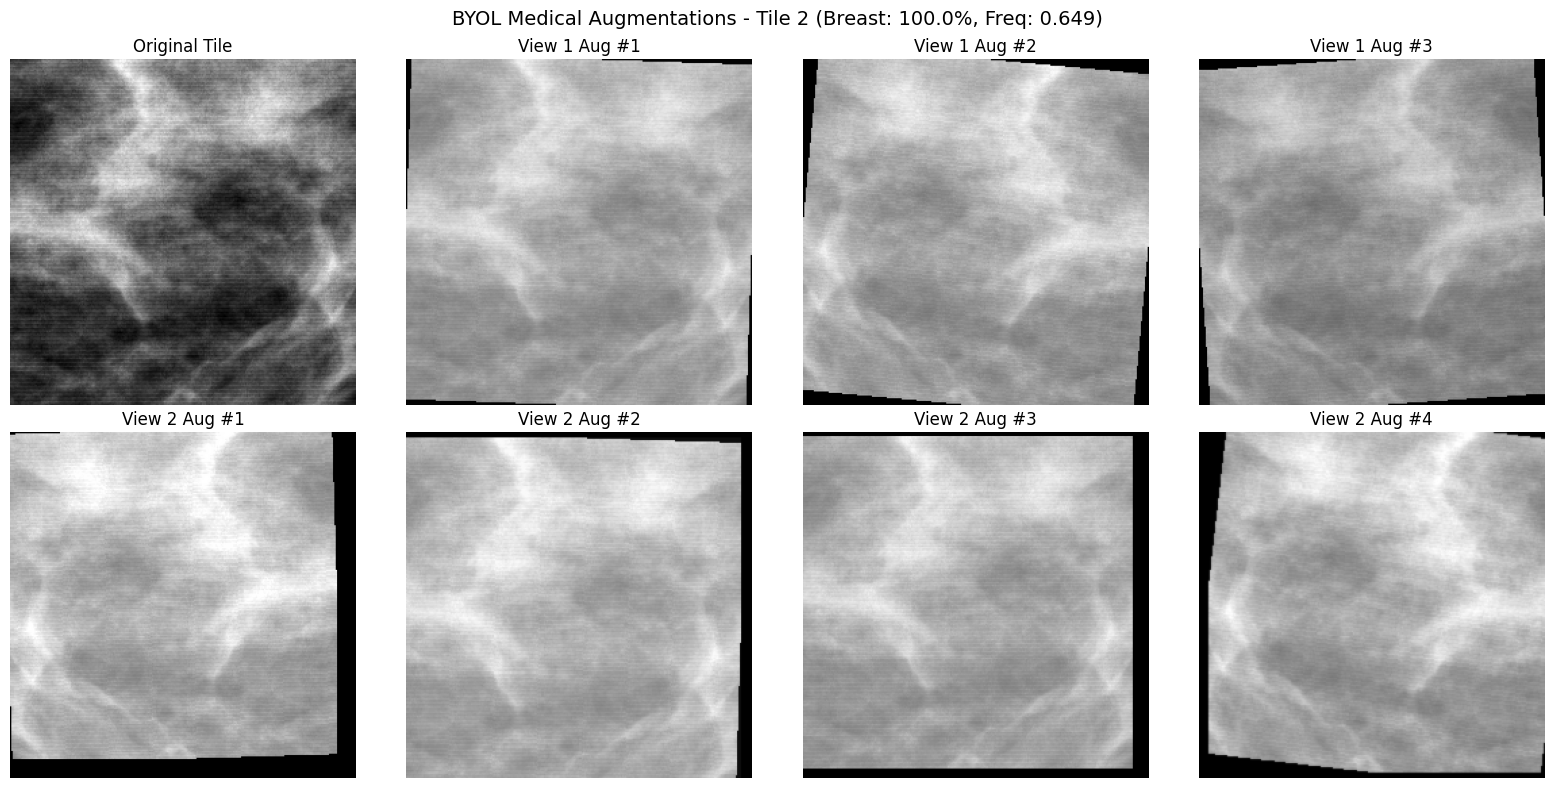

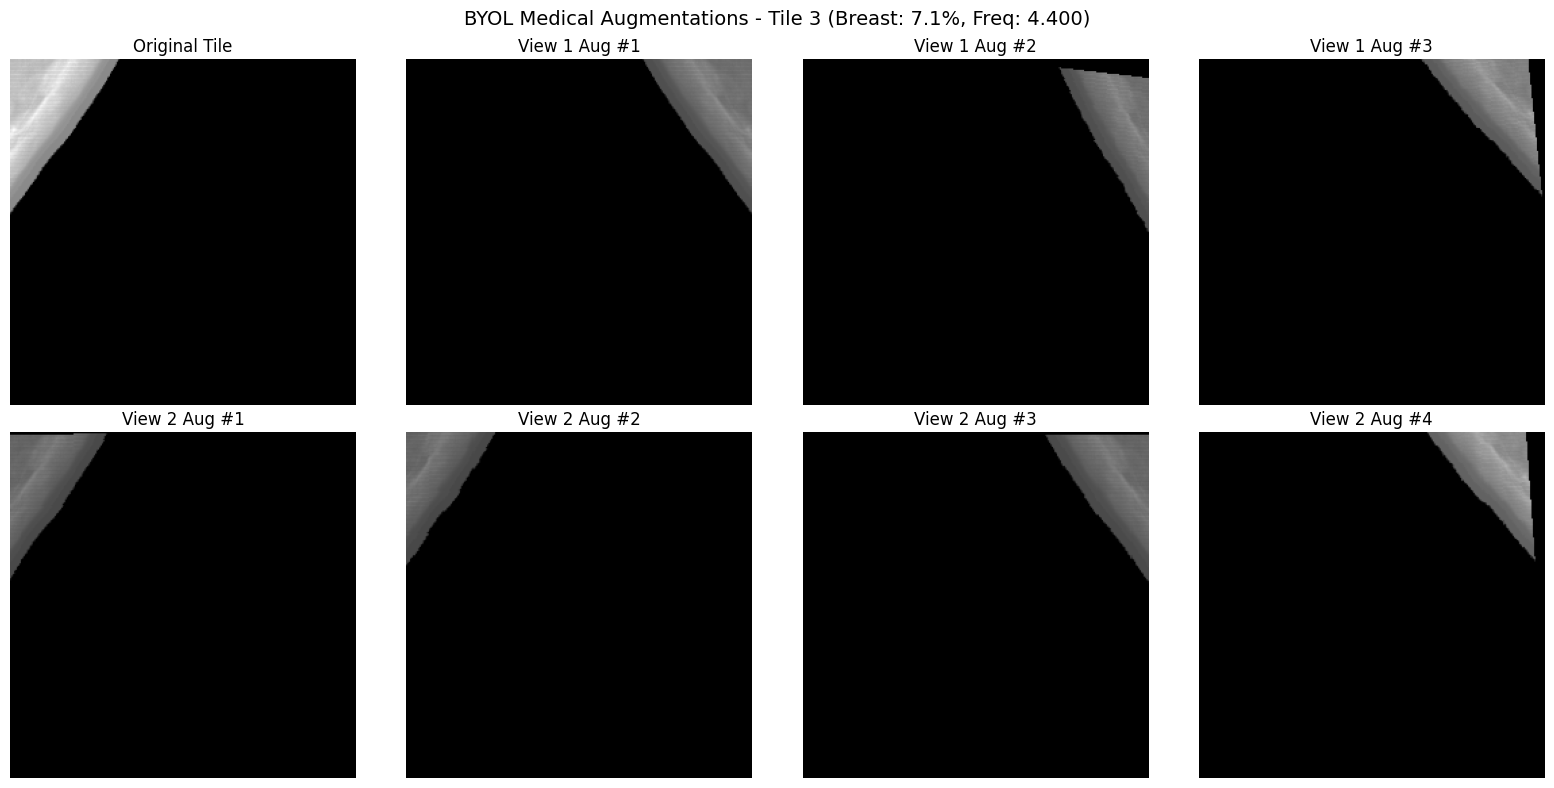

In [8]:
def display_byol_augmentations(results, num_augmentations=6):
    """
    Display the medical-optimized BYOL augmentations on sample tiles
    """
    if not results:
        print("❌ No results to display")
        return
    
    # Create the medical transforms
    transform = create_medical_transforms(TILE_SIZE)
    
    # Select a result with tiles
    result = None
    for r in results:
        if len(r['tiles']) > 3:
            result = r
            break
    
    if result is None:
        print("❌ No results with sufficient tiles found")
        return
    
    # Select a few interesting tiles (mix of breast tissue and frequency energy tiles)
    sample_tiles = []
    if len(result['breast_tiles']) > 0:
        sample_tiles.extend(random.sample(result['breast_tiles'], min(2, len(result['breast_tiles']))))
    if len(result['freq_tiles']) > 0:
        sample_tiles.extend(random.sample(result['freq_tiles'], min(2, len(result['freq_tiles']))))
    
    if not sample_tiles:
        sample_tiles = random.sample(result['tiles'], min(3, len(result['tiles'])))
    
    for i, (tile_img, coords, breast_ratio, freq_energy) in enumerate(sample_tiles[:3]):
        # Convert tile to PIL Image and prepare for transforms
        if tile_img.max() <= 1.0:
            tile_img = (tile_img * 255).astype(np.uint8)
        
        # Convert to grayscale then RGB (same as in training pipeline)
        pil_tile = Image.fromarray(tile_img.astype(np.uint8))
        if pil_tile.mode != 'L':
            pil_tile = pil_tile.convert('L')
        pil_tile = pil_tile.convert('RGB')  # Replicate grayscale channel
        
        # Generate multiple augmentations
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f"BYOL Medical Augmentations - Tile {i+1} (Breast: {breast_ratio:.1%}, Freq: {freq_energy:.3f})", fontsize=14)
        
        # Original tile
        axes[0, 0].imshow(tile_img, cmap='gray')
        axes[0, 0].set_title("Original Tile")
        axes[0, 0].axis('off')
        
        # Show multiple augmented versions
        for j in range(1, 8):
            row = j // 4
            col = j % 4
            
            # Apply BYOL transforms
            views = transform(pil_tile)
            view1, view2 = views
            
            # Convert back to display format
            if j <= 3:
                # Show View 1 transforms (lighter)
                display_tensor = view1
                title = f"View 1 Aug #{j}"
            else:
                # Show View 2 transforms (stronger)
                display_tensor = view2
                title = f"View 2 Aug #{j-3}"
            
            # Denormalize for display
            display_img = display_tensor.clone()
            display_img = display_img * 0.5 + 0.5  # Reverse normalization
            display_img = torch.clamp(display_img, 0, 1)
            
            # Convert to numpy and show
            display_np = display_img.permute(1, 2, 0).numpy()
            axes[row, col].imshow(display_np)
            axes[row, col].set_title(title)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()

# Display BYOL augmentations
if results:
    print("🎯 Demonstrating Medical-Optimized BYOL Augmentations")
    print("View 1: Lighter augmentations (horizontal flip, ±7° rotation, mild brightness/contrast)")
    print("View 2: Stronger augmentations (+ translation, scaling, mild blur)")
    print("Note: No strong color jitter/solarization to preserve medical details\n")
    
    display_byol_augmentations(results)

🏥 === MEDICAL-OPTIMIZED BYOL PIPELINE SUMMARY ===
📊 Dataset Statistics:
   • Total images processed: 10
   • Total tiles generated: 709
   • Average tiles per image: 70.9
   • Average breast tissue percentage: 65.6%

🎯 Tile Selection Strategy:
   • Breast tissue tiles (≥10.0% tissue): 653 (92.1%)
   • Frequency energy tiles (≥0.010 energy): 56 (7.9%)
   • Tile size: 256×256 pixels
   • Tile stride: 128 pixels (50% overlap)

🔬 Medical Improvements vs Original:
   ✅ Lowered breast ratio threshold: 0.3 → 0.1 (captures peripheral regions)
   ✅ Added frequency energy detection: micro-calcification sensitivity
   ✅ Gentle segmentation: preserves medical details
   ✅ Grayscale-appropriate preprocessing: L→RGB replication

🎛️ BYOL Augmentation Optimizations:
   ✅ Medical-safe rotations: ±7° (preserves anatomy)
   ✅ Mild brightness/contrast: no color distortion
   ✅ Light blur: preserves calcification details
   ✅ No solarization/strong color jitter: medical data integrity

⚡ A100 Performance O

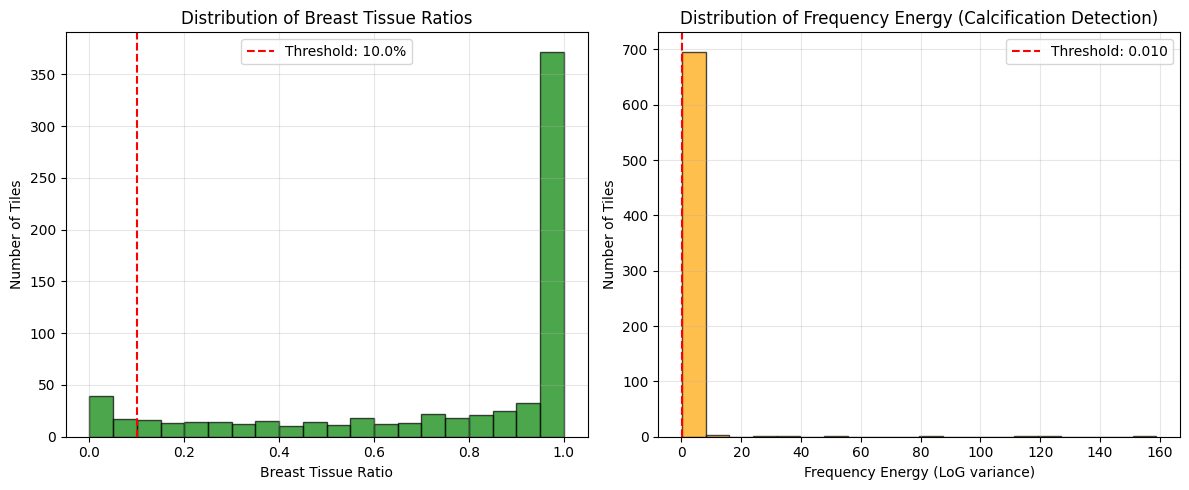


🚀 Ready for A100 training with: sbatch submit_byol.sbatch


In [9]:
# Comprehensive summary of the medical-optimized pipeline
if results:
    total_tiles = sum(len(result['tiles']) for result in results)
    total_breast_tiles = sum(len(result['breast_tiles']) for result in results)
    total_freq_tiles = sum(len(result['freq_tiles']) for result in results)
    avg_tiles_per_image = total_tiles / len(results) if results else 0
    avg_breast_percentage = np.mean([result['breast_percentage'] for result in results])
    
    print("🏥 === MEDICAL-OPTIMIZED BYOL PIPELINE SUMMARY ===")
    print(f"📊 Dataset Statistics:")
    print(f"   • Total images processed: {len(results)}")
    print(f"   • Total tiles generated: {total_tiles:,}")
    print(f"   • Average tiles per image: {avg_tiles_per_image:.1f}")
    print(f"   • Average breast tissue percentage: {avg_breast_percentage:.1f}%")
    
    print(f"\n🎯 Tile Selection Strategy:")
    print(f"   • Breast tissue tiles (≥{MIN_BREAST_RATIO:.1%} tissue): {total_breast_tiles:,} ({total_breast_tiles/total_tiles*100:.1f}%)")
    print(f"   • Frequency energy tiles (≥{MIN_FREQ_ENERGY:.3f} energy): {total_freq_tiles:,} ({total_freq_tiles/total_tiles*100:.1f}%)")
    print(f"   • Tile size: {TILE_SIZE}×{TILE_SIZE} pixels")
    print(f"   • Tile stride: {TILE_STRIDE} pixels ({TILE_STRIDE/TILE_SIZE*100:.0f}% overlap)")
    
    print(f"\n🔬 Medical Improvements vs Original:")
    print(f"   ✅ Lowered breast ratio threshold: 0.3 → {MIN_BREAST_RATIO} (captures peripheral regions)")
    print(f"   ✅ Added frequency energy detection: micro-calcification sensitivity")
    print(f"   ✅ Gentle segmentation: preserves medical details")
    print(f"   ✅ Grayscale-appropriate preprocessing: L→RGB replication")
    
    print(f"\n🎛️ BYOL Augmentation Optimizations:")
    print(f"   ✅ Medical-safe rotations: ±7° (preserves anatomy)")
    print(f"   ✅ Mild brightness/contrast: no color distortion") 
    print(f"   ✅ Light blur: preserves calcification details")
    print(f"   ✅ No solarization/strong color jitter: medical data integrity")
    
    print(f"\n⚡ A100 Performance Optimizations:")
    print(f"   ✅ Mixed precision training: autocast + GradScaler")
    print(f"   ✅ Per-step momentum updates: better convergence")
    print(f"   ✅ Optimized hyperparameters: LR=3e-4, WD=1e-4 (batch=8)")
    print(f"   ✅ Multi-label classification ready: [mass, calcification]")
    
    # Distribution visualization
    breast_ratios = []
    freq_energies = []
    for result in results:
        for tile_img, coords, breast_ratio, freq_energy in result['tiles']:
            breast_ratios.append(breast_ratio)
            freq_energies.append(freq_energy)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Breast ratio distribution
    ax1.hist(breast_ratios, bins=20, alpha=0.7, edgecolor='black', color='green')
    ax1.axvline(MIN_BREAST_RATIO, color='red', linestyle='--', label=f'Threshold: {MIN_BREAST_RATIO:.1%}')
    ax1.set_xlabel('Breast Tissue Ratio')
    ax1.set_ylabel('Number of Tiles')
    ax1.set_title('Distribution of Breast Tissue Ratios')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Frequency energy distribution
    ax2.hist(freq_energies, bins=20, alpha=0.7, edgecolor='black', color='orange')
    ax2.axvline(MIN_FREQ_ENERGY, color='red', linestyle='--', label=f'Threshold: {MIN_FREQ_ENERGY:.3f}')
    ax2.set_xlabel('Frequency Energy (LoG variance)')
    ax2.set_ylabel('Number of Tiles')
    ax2.set_title('Distribution of Frequency Energy (Calcification Detection)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🚀 Ready for A100 training with: sbatch submit_byol.sbatch")
    
else:
    print("❌ No results to summarize - please check the data directory path")